**PNEUMONIA CLASSIFICATION**

Load the dataset from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Import necessary libraries

In [2]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4 MB 6.7 kB/s 
     |████████████████████████████████| 4.0 MB 20.1 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.


In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
from PIL import Image

import torch
from fastai.vision import *

Check if GPU is available

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
mainDIR = os.listdir('/content/drive/My Drive/ChestPneumonia/chest_xray/chest_xray')
print(mainDIR)

['test', 'train', 'val', '.DS_Store', 'models', 'PneumoniaRESNET50.pkl']


In [7]:
train_folder= '/content/drive/My Drive/ChestPneumonia/chest_xray/chest_xray/train/'

In [8]:
train_n = train_folder+'NORMAL/'
train_p = train_folder+'PNEUMONIA/'

Number of normal images

In [9]:
path, dirs, files = next(os.walk(train_n))
file_count = len(files)
print(file_count)

1342


Number of pneumonia images

In [10]:
path, dirs, files = next(os.walk(train_p))
file_count = len(files)
print(file_count)

3876


**Preparing image for modelling**

Get images from train, test folders and use 20% for validation set. The images are normalized with respect to mean, std of imagenet model.  

In [ ]:
path = Path('/content/drive/My Drive/ChestPneumonia/chest_xray/chest_xray')

np.random.seed(42)

data = ImageDataBunch.from_folder(path, 
                                  train="train",
                                  test="test", 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(), 
                                  size=64, 
                                  num_workers=4, 
                                  bs = 16) \
.normalize(imagenet_stats)

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
data.classes

Create a CNN model with resnset50 architecture with accuracy as metrics 

In [ ]:
learn = cnn_learner(data, 
                    models.resnet50, 
                    metrics=accuracy)

Train the model for four cycles

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.497376,0.368068,0.888145,06:11
1,0.300318,0.233869,0.916826,02:37


epoch,train_loss,valid_loss,accuracy,time
0,0.497376,0.368068,0.888145,06:11
1,0.300318,0.233869,0.916826,02:37
2,0.261772,0.165731,0.937859,02:35
3,0.191270,0.159873,0.937859,02:40


Check performance of the model after initial training 

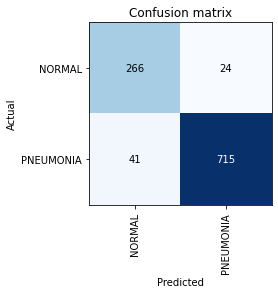

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
learn.save('train1')

Freeze the model and find the optimum learning rate

In [18]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


The plot represents Learning Rate with respect to loss. The optimal learning rate is found by finding the minimum point of the loss. 

In [ ]:
learn.recorder.plot()

Train the remaining layers with the optimal learning rate

In [20]:
learn.fit_one_cycle(8, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time


epoch,train_loss,valid_loss,accuracy,time
0,0.171011,0.123604,0.956979,02:40
1,0.195089,0.199375,0.919694,02:42
2,0.180276,0.109877,0.970363,02:44
3,0.164974,0.105333,0.978011,02:42
4,0.132492,0.131500,0.953155,02:43
5,0.095962,0.085519,0.969407,02:44
6,0.086044,0.082056,0.970363,02:43
7,0.054454,0.067954,0.976099,02:42


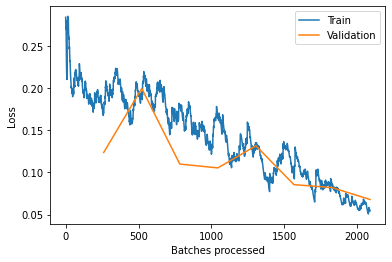

In [21]:
learn.recorder.plot_losses()

Confusion matrix of the final model

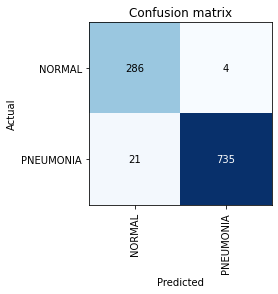

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Predict on unseen image


In [ ]:
category, tensor, probs = learn.predict(open_image(f"{path}/val/PNEUMONIA/person1946_bacteria_4874.jpeg"))

In [ ]:
print(category,probs)

In [25]:
learn.save('PneumoniaRESNET50')

Serialize the model so that it can be used for prediction in other environments 

In [26]:
learn.export('PneumoniaRESNET50.pkl')